# Import Libraries

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Building Regression Classifier

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.6.0'

In [5]:
keras.__version__

'2.6.0'

### Load the dataset:

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 4s 0us/step


In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
X_train_full.dtype

dtype('uint8')

### Split the full training set into a validation set and a training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

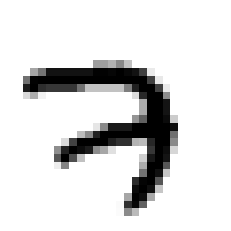

In [10]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [11]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [12]:
X_valid.shape

(5000, 28, 28)

In [13]:
X_test.shape

(10000, 28, 28)

### Show Sample Images

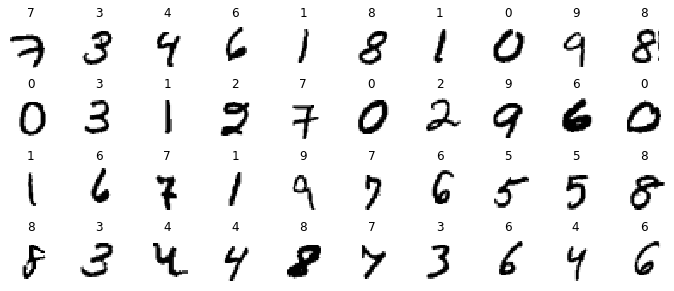

In [15]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Build a simple dense network and find the optimal learning rate. Define callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [16]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [17]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

C:\Users\aman.khatri91425\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train the model for just 1 epoch:

In [20]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.5710 - val_loss: nan - val_accuracy: 0.0958


### Plot the loss as a functionof the learning rate

Text(0, 0.5, 'Loss')

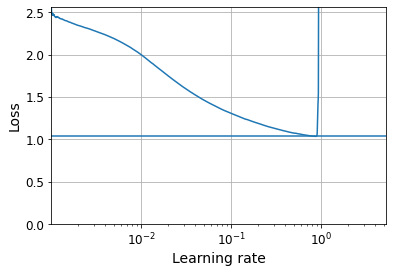

In [21]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

### The loss starts shooting back up violently when the learning rate goes over 6e-1, so use half of that, at 3e-1:

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

C:\Users\aman.khatri91425\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [26]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2363 - accuracy: 0.9263 - val_loss: 0.0975 - val_accuracy: 0.9712
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0954 - accuracy: 0.9698 - val_loss: 0.0989 - val_accuracy: 0.9704
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0665 - accuracy: 0.9791 - val_loss: 0.0759 - val_accuracy: 0.9766
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0470 - accuracy: 0.9849 - val_loss: 0.0727 - val_accuracy: 0.9804
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0347 - accuracy: 0.9885 - val_loss: 0.0865 - val_accuracy: 0.9774
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0776 - val_accuracy: 0.9804
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0243 - accuracy: 0.9919 - val_loss: 0.0836 - val_ac

In [27]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 897us/step - loss: 0.0799 - accuracy: 0.9805


[0.07990094274282455, 0.9804999828338623]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [30]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 15276), started 0:36:43 ago. (Use '!kill 15276' to kill it.)